# master report file is here: https://drive.google.com/drive/u/0/folders/0B5UtqzgzoY-ZWVRNNGE3R1Z0Uzg

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
from sys import path
import os
import numpy as np
import pandas as pd
import warnings
PATH_TO_CSV = '/home/rui/blacksid/LocalTest/out/'
import re
from scipy.stats.mstats import kruskalwallis
from scipy.stats import ttest_rel, wilcoxon
import itertools

In [2]:
class CsvAnalyst(object):
    
    def __init__(self, product=None, full_model=True):
        ## constructer
        if product == None:
            raise Exception("must give a product when initializing")
        else:
            self.benchmark_daily_pnl = pd.read_csv(PATH_TO_CSV + '{}_benchmark_daily_pnl.csv'.format(product),index_col = 0)
            self.benchmark_num_rounds = pd.read_csv(PATH_TO_CSV + '{}_benchmark_daily_num_rounds.csv'.format(product),index_col = 0)
            self.benchmark_order_win = pd.read_csv(PATH_TO_CSV + '{}_benchmark_daily_order_win.csv'.format(product),index_col = 0)
            self.benchmark_order_profit = pd.read_csv(PATH_TO_CSV + '{}_benchmark_daily_order_profit.csv'.format(product),index_col = 0)
            self.trade_day_list = self.benchmark_daily_pnl.index
        if not full_model:
            pattern = 'roll:'+'.*'+'spreadcoef:0.0'
            prog = re.compile(pattern)
            spread_0_colums = [i for i in benchmark_daily_pnl.columns if prog.match(i)]
            self.benchmark_daily_pnl = self.benchmark_daily_pnl[spread_0_colums]
            self.benchmark_num_rounds = self.benchmark_num_rounds[spread_0_colums]
            self.benchmark_order_win = self.benchmark_order_win[spread_0_colums]
            self.benchmarl_order_profit = self.benchmark_order_profit[spread_0_colums]
            
    #@param datelist: the date range that we are interested in.        
    def __get_day_best_param(self, roll, date):
        if date not in self.trade_day_list:
            warnings.warn("given date is not a trade day")
            return -1
        index = self.trade_day_list.get_loc(date)
        if index < roll:
            raise RuntimeError('roll window too large')
        temp = np.sum(self.benchmark_daily_pnl[index-roll:index], axis = 0)
        return temp.argmax()

    def get_best_param(self, roll, date_list):
        param_list = []
        tday_list = []
        for date in date_list:
            if date not in self.trade_day_list:
                continue
            param_list.append(self.__get_day_best_param(roll, date))
            tday_list.append(date)
        result = dict(zip(tday_list,param_list))
        return result

    def get_best_param_of_last_N_days(self, roll, compare_window = 59):
        param_benchmark = []
        length = len(self.benchmark_daily_pnl)
        for i in range(length - compare_window, length):
            temp = np.sum(self.benchmark_daily_pnl[i-roll:i], axis = 0)
            param_benchmark.append(temp.argmax())
        return param_benchmark
    
    def get_pnl_list(self, roll, date_list):
        pnl_benchmark = []
        tday_list = []
        for date in date_list:
            if date not in self.trade_day_list:
                continue
            param = (self.__get_day_best_param(roll, date))
            index = self.trade_day_list.get_loc(date)
            pnl_benchmark.append(self.benchmark_daily_pnl[param][index])
            tday_list.append(date)
        return zip(tday_list,pnl_benchmark)
    
    def compare_roll_range(self, date_list, roll_range=np.arange(50,200)):
        mean_pnl_list = []
        for roll in roll_range:
            temp = self.get_pnl_list(roll, date_list)
            mean_pnl_list.append(np.mean([i[1] for i in temp]))
        plt.plot(roll_range,mean_pnl_list)
    
    def report_given_param(self, param_list, date_list):
        pnl_list = []
        num_rounds_list = []
        order_win_list = []
        day_win_ratio_list = []
        order_profit_list = []
        for param in param_list:
            num_rounds = 0
            pnl = 0
            order_win = 0
            order_profit = 0
            day_win_ratio = 0
            num_days = 0
            column = 'roll:{}_sd:{}_spreadcoef:{}'.format(*param)
            for date in date_list:
                if date not in self.trade_day_list:
                    continue
                num_days += 1
                index = self.trade_day_list.get_loc(date)
                if self.benchmark_daily_pnl[column][index] > 0:
                    day_win_ratio += 1
                pnl += self.benchmark_daily_pnl[column][index]
                num_rounds += self.benchmark_num_rounds[column][index]
                if not np.isnan(self.benchmark_order_win[column][index]):
                    order_win += self.benchmark_num_rounds[column][index] * self.benchmark_order_win[column][index]
                if not np.isnan(self.benchmark_order_profit[column][index]):
                    order_profit += self.benchmark_num_rounds[column][index] * self.benchmark_order_profit[column][index]
            if num_rounds:
                order_win = float(order_win) / num_rounds
                order_profit = float(order_profit) / num_rounds
            else:
                order_win = -1
                order_profit = -1
            day_win_ratio = float(day_win_ratio) / num_days
            pnl_list.append(pnl)
            num_rounds_list.append(num_rounds)
            order_win_list.append(order_win)
            day_win_ratio_list.append(day_win_ratio)
            order_profit_list.append(order_profit)
        result = pd.DataFrame({ "pnl": pnl_list,
                                "num_rounds": num_rounds_list,
                                "order_win": order_win_list,
                                "day_win_ratio": day_win_ratio_list,
                                "order_profit": order_profit_list})
        result.index = param_list
        return result
            
            
            
    def report(self, roll, date_list):
        num_rounds = 0
        pnl = 0
        order_win = 0
        order_profit = 0
        day_win_ratio = 0
        num_days = 0
        for date in date_list:
            if date not in self.trade_day_list:
                continue
            num_days += 1
            index = self.trade_day_list.get_loc(date)
            param = (self.__get_day_best_param(roll, date))
            if self.benchmark_daily_pnl[param][index] > 0:
                day_win_ratio += 1
            pnl += self.benchmark_daily_pnl[param][index]
            num_rounds += self.benchmark_num_rounds[param][index]
            if not np.isnan(self.benchmark_order_win[param][index]):
                order_win += self.benchmark_num_rounds[param][index] * self.benchmark_order_win[param][index]
            if not np.isnan(self.benchmark_order_profit[param][index]):
                order_profit += self.benchmark_num_rounds[param][index] * self.benchmark_order_profit[param][index]
        if num_rounds != 0 :
            order_win = float(order_win) / num_rounds
            order_profit = float(order_profit) / num_rounds
        else:
            order_win = -1
            order_profit = -1
        day_win_ratio = float(day_win_ratio) / num_days
        result = pd.DataFrame({ "pnl": [pnl],
                                "num_rounds": [num_rounds],
                                "order_win": [order_win],
                                "num_days": [num_days],
                                "day_win_ratio": [day_win_ratio],
                                "order_profit": [order_profit]})
        return result

In [3]:
date_list = [str(x).split(' ')[0] for x in pd.date_range('2016-07-16','2016-08-20').tolist()]
#@param roll: number of days we use to find the best param.
roll = 100

## get full report for a date range(rolling parameter):

In [17]:
test_ca = CsvAnalyst('al')

# compare different params:

In [18]:
roll_list = np.concatenate((np.arange(200,500,200), np.arange(500, 3500, 500),[5000, 8000])) #11 params
sd_list = np.concatenate((np.arange(1, 2.1, 0.25),[3,5]))#11 params
spread_list = np.concatenate((np.arange(1, 2.1, 0.25),[3,5]))#11 params
param_list = list(itertools.product(roll_list, sd_list, spread_list))
result = test_ca.report_given_param(param_list,date_list)

### specify the criterion:

In [22]:
result[(result['order_win']>0.85).multiply(result['order_profit']>10).multiply(result['pnl']>5000)]

,day_win_ratio,num_rounds,order_profit,order_win,pnl
"(1500, 2.0, 1.5)",0.96,284,29.299296,0.852113,6389.0
"(1500, 3.0, 1.5)",0.92,207,34.700483,0.850242,5382.0
"(2000, 1.0, 1.5)",0.88,259,29.617761,0.857143,5770.0
"(2000, 1.25, 1.5)",0.88,259,29.617761,0.857143,5770.0
"(2000, 1.5, 1.5)",0.88,257,29.700389,0.856031,5732.0
"(2000, 1.75, 1.5)",0.88,257,29.894942,0.856031,5782.0
"(2000, 2.0, 1.5)",0.88,251,30.055777,0.852590,5556.0
"(2500, 1.0, 1.5)",0.88,245,29.714286,0.873469,5223.0
"(2500, 1.25, 1.5)",0.88,245,29.714286,0.873469,5223.0
"(2500, 1.5, 1.5)",0.88,243,29.802469,0.872428,5185.0


In [15]:
rrr = result[(result['order_win']>0.85).multiply(result['order_profit']>30).multiply(result['pnl']>10000)]

In [16]:
rrr.sort_values('pnl', ascending=False)

,day_win_ratio,num_rounds,order_profit,order_win,pnl
"(1000, 2.0, 1.25)",0.96,803,32.723285,0.872976,24099.4725
"(1000, 1.5, 1.25)",0.96,808,32.280260,0.871287,23905.1250
"(1000, 1.75, 1.25)",0.96,808,32.280260,0.871287,23905.1250
"(1000, 1.0, 1.25)",0.96,808,32.280260,0.871287,23905.1250
"(1000, 1.25, 1.25)",0.96,808,32.280260,0.871287,23905.1250
"(1500, 1.0, 1.25)",1.00,733,35.014829,0.892224,23069.5725
"(1500, 1.5, 1.25)",1.00,733,35.014829,0.892224,23069.5725
"(1500, 1.75, 1.25)",1.00,733,35.014829,0.892224,23069.5725
"(1500, 1.25, 1.25)",1.00,733,35.014829,0.892224,23069.5725
"(1500, 2.0, 1.25)",1.00,720,35.225785,0.890278,22834.8650


In [23]:
test_ca = CsvAnalyst('hc')
result = test_ca.report_given_param(param_list,date_list)

In [25]:
result[(result['order_win']>0.80).multiply(result['order_profit']>10).multiply(result['pnl']>500)]

,day_win_ratio,num_rounds,order_profit,order_win,pnl
"(3000, 1.75, 1.75)",0.615385,226,11.048159,0.800885,1706.875
"(3000, 2.0, 1.5)",0.769231,240,10.620550,0.808333,1718.618
"(3000, 2.0, 1.75)",0.692308,204,12.577103,0.803922,1745.412
"(5000, 1.75, 1.75)",0.692308,158,11.354443,0.803797,893.118
"(5000, 2.0, 1.25)",0.769231,163,10.999712,0.809816,942.066
"(5000, 2.0, 1.5)",0.769231,162,11.503463,0.820988,1012.674
"(5000, 2.0, 1.75)",0.769231,147,13.903912,0.809524,1192.988
"(5000, 3.0, 5.0)",0.615385,20,59.653850,0.800000,766.784
"(8000, 1.0, 1.75)",0.615385,161,11.110491,0.801242,947.827
"(8000, 1.25, 1.75)",0.692308,153,12.656529,0.823529,1155.471


# rolling param for other contracts:

In [15]:
test_ca = CsvAnalyst('zn')
test_ca.report(roll, date_list)

,day_win_ratio,num_days,num_rounds,order_profit,order_win,pnl
0,1.0,59,4425,16.983051,0.820791,72639.0


In [16]:
test_ca = CsvAnalyst('au')
test_ca.report(roll, date_list)

,day_win_ratio,num_days,num_rounds,order_profit,order_win,pnl
0,0.932203,59,1408,87.764915,0.939631,114863.0


In [17]:
test_ca = CsvAnalyst('al')
test_ca.report(roll, date_list)

,day_win_ratio,num_days,num_rounds,order_profit,order_win,pnl
0,0.983051,59,2110,14.343602,0.753555,27735.0


In [5]:
test_ca = CsvAnalyst('cu')
test_ca.report(roll, date_list) 

,day_win_ratio,num_days,num_rounds,order_profit,order_win,pnl
0,1.0,59,5101,31.641118,0.828857,155932.6975


## without spread guard

In [8]:
test_ca = CsvAnalyst('cu', False)
test_ca.report(roll, date_list)

,day_win_ratio,num_days,num_rounds,order_profit,order_win,pnl
0,0.949153,59,3334,36.920045,0.833533,117105.055


In [20]:
class StrategyCompare(object):
    def __init__(self, strategy=None, product=None):
        if strategy == None or product == None:
            raise Exception("must give a strategy and product when initializing")
        else:
            self.benchmark_daily_pnl = pd.read_csv(PATH_TO_CSV + '{}_benchmark_daily_pnl.csv'.format(product),index_col = 0)
            self.benchmark_num_rounds = pd.read_csv(PATH_TO_CSV + '{}_benchmark_daily_num_rounds.csv'.format(product),index_col = 0)
            self.benchmark_order_win = pd.read_csv(PATH_TO_CSV + '{}_benchmark_daily_order_win.csv'.format(product),index_col = 0)
            self.benchmark_order_profit = pd.read_csv(PATH_TO_CSV + '{}_benchmark_daily_order_profit.csv'.format(product),index_col = 0)
            self.trade_day_list = self.benchmark_daily_pnl.index
            pattern = 'roll:'+'.*'+'spreadcoef:0.0'
            prog = re.compile(pattern)
            spread_0_colums = [i for i in self.benchmark_daily_pnl.columns if prog.match(i)]
            self.benchmark_daily_pnl = self.benchmark_daily_pnl[spread_0_colums]
            self.benchmark_num_rounds = self.benchmark_num_rounds[spread_0_colums]
            self.benchmark_order_win = self.benchmark_order_win[spread_0_colums]
            self.benchmarl_order_profit = self.benchmark_order_profit[spread_0_colums]
            self.strategy_daily_pnl = pd.read_csv(PATH_TO_CSV + '{}/{}_{}_daily_pnl.csv'.format(strategy,product,strategy), index_col = 0)
            self.strategy_num_rounds = pd.read_csv(PATH_TO_CSV + '{}/{}_{}_daily_num_rounds.csv'.format(strategy,product,strategy), index_col = 0)
            self.strategy_order_win = pd.read_csv(PATH_TO_CSV + '{}/{}_{}_daily_order_win.csv'.format(strategy,product,strategy), index_col = 0)
            self.strategy_order_profit = pd.read_csv(PATH_TO_CSV + '{}/{}_{}_daily_order_profit.csv'.format(strategy,product,strategy), index_col = 0)
            
    def __get_day_best_param(self, roll, date):
        if date not in self.trade_day_list:
            warnings.warn("given date is not a trade day")
            return -1
        index = self.trade_day_list.get_loc(date)
        if index < roll:
            raise RuntimeError('roll window too large')
        temp1 = np.sum(self.benchmark_daily_pnl[index-roll:index], axis = 0)
        temp2 = np.sum(self.strategy_daily_pnl[index-roll:index], axis = 0)
        return temp1.argmax(), temp2.argmax()
    
    def get_best_param(self, roll, date_list):
        benchmark_param_list = []
        strategy_param_list = []
        tday_list = []
        for date in date_list:
            if date not in self.trade_day_list:
                continue
            benchmark_param_list.append(self.__get_day_best_param(roll, date)[0])
            strategy_param_list.append(self.__get_day_best_param(roll, date)[1])
            tday_list.append(date)
        result = dict(zip(tday_list,zip(benchmark_param_list,strategy_param_list)))
        return result
    
    def pnl_list_given_param(self, roll_param, sd_coef, date_list):
        pnl_benchmark = []
        pnl_strategy = []
        tday_list = []
        benchmark_index = 'roll:{}_sd:{}_spreadcoef:0.0'.format(roll_param,sd_coef)
        strategy_index = 'roll:{}_sd:{}'.format(roll_param, sd_coef)
        for date in date_list:
            if date not in self.trade_day_list:
                continue
            index = self.trade_day_list.get_loc(date)
            pnl_benchmark.append(self.benchmark_daily_pnl[benchmark_index][index])
            pnl_strategy.append(self.strategy_daily_pnl[strategy_index][index])
            tday_list.append(date)
        return zip(tday_list,pnl_benchmark,pnl_strategy)
    
    def get_pnl_list(self, roll, date_list):
        pnl_benchmark = []
        pnl_strategy = []
        tday_list = []
        for date in date_list:
            if date not in self.trade_day_list:
                continue
            param = (self.__get_day_best_param(roll, date))
            index = self.trade_day_list.get_loc(date)
            pnl_benchmark.append(self.benchmark_daily_pnl[param[0]][index])
            pnl_strategy.append(self.strategy_daily_pnl[param[1]][index])
            tday_list.append(date)
        return zip(tday_list,pnl_benchmark,pnl_strategy)
    
    def report(self, date_list, roll_range = np.arange(50,200)):
        mean_greater_than_bench = []
        median_greater_than_bench = []
        mean_bench = []
        mean_strategy = []
        wilcoxon_pvalue_list = []
        ttrel_pvalue_list = []
        for roll in roll_range:
            temp = self.get_pnl_list(roll, date_list)
            pnl_benchmark = [i[1] for i in temp]
            pnl_strategy = [i[2] for i in temp]
            result = wilcoxon(pnl_benchmark, pnl_strategy)
            wilcoxon_pvalue_list.append(result.pvalue)
            result = ttest_rel(pnl_benchmark, pnl_strategy)
            ttrel_pvalue_list.append(result.pvalue)
            mean_greater_than_bench.append(np.mean(pnl_strategy)-np.mean(pnl_benchmark))
            mean_bench.append(np.mean(pnl_benchmark))
            mean_strategy.append(np.mean(pnl_strategy))
            median_greater_than_bench.append(np.median(pnl_strategy)-np.median(pnl_benchmark))
        wilcoxon_pvalue_list = np.asarray(wilcoxon_pvalue_list)
        ttrel_pvalue_list = np.asarray(ttrel_pvalue_list)
        mean_greater_than_bench = np.asarray(mean_greater_than_bench)
        median_greater_than_bench = np.asarray(median_greater_than_bench)
        print "wilcoxon test reject hypothesis: \t {:.2f} %".format(np.mean(wilcoxon_pvalue_list<0.2) * 100)
        print "dependent t test reject hypothesis: \t {:.2f} %".format(np.mean(ttrel_pvalue_list<0.2) * 100)
        print "mean greater than bench: \t {:.2f} %".format(np.mean(mean_greater_than_bench>0) * 100)
        print "median greater than bench: \t {:.2f} %".format(np.mean(median_greater_than_bench>0) * 100)
        self.wilcoxon_pvalue_list = wilcoxon_pvalue_list
        self.ttrel_pvalue_list = ttrel_pvalue_list
        self.mean_greater_than_bench = mean_greater_than_bench
        self.median_greater_than_bench = median_greater_than_bench
        plt.plot(roll_range,mean_bench)
        plt.plot(roll_range,mean_strategy, 'r')
    
    

wilcoxon test reject hypothesis: 	 0.00 %
dependent t test reject hypothesis: 	 0.00 %
mean greater than bench: 	 98.00 %
median greater than bench: 	 0.00 %


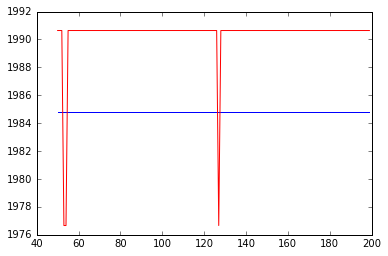

In [10]:
test_sc = StrategyCompare('OU','cu')
test_sc.report(date_list)

/home/greedy/anaconda2/lib/python2.7/site-packages/scipy/stats/morestats.py:2384: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


wilcoxon test reject hypothesis: 	 56.67 %
dependent t test reject hypothesis: 	 61.33 %
mean greater than bench: 	 94.67 %
median greater than bench: 	 84.00 %


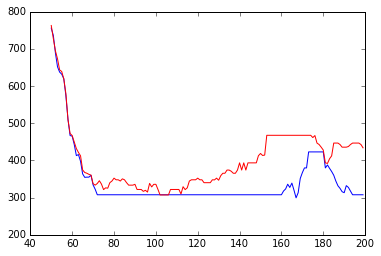

In [11]:
test_sc = StrategyCompare('OU','au')
test_sc.report(date_list)

wilcoxon test reject hypothesis: 	 1.33 %
dependent t test reject hypothesis: 	 2.67 %
mean greater than bench: 	 81.33 %
median greater than bench: 	 3.33 %


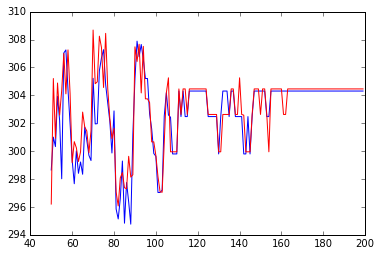

In [12]:
test_sc = StrategyCompare('OU','al')
test_sc.report(date_list)

wilcoxon test reject hypothesis: 	 38.00 %
dependent t test reject hypothesis: 	 37.33 %
mean greater than bench: 	 18.67 %
median greater than bench: 	 23.33 %


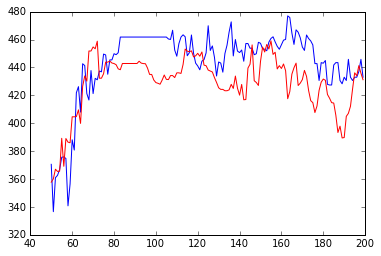

In [13]:
test_sc = StrategyCompare('OU','pb')
test_sc.report(date_list)

wilcoxon test reject hypothesis: 	 52.67 %
dependent t test reject hypothesis: 	 38.67 %
mean greater than bench: 	 4.67 %
median greater than bench: 	 20.67 %


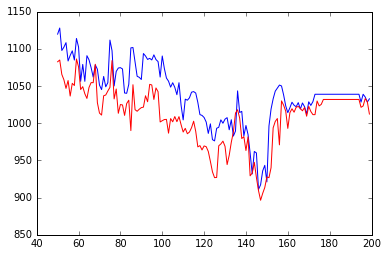

In [14]:
test_sc = StrategyCompare('OU','ru')
test_sc.report(date_list)

wilcoxon test reject hypothesis: 	 73.85 %
dependent t test reject hypothesis: 	 80.00 %
mean greater than bench: 	 100.00 %
median greater than bench: 	 62.31 %


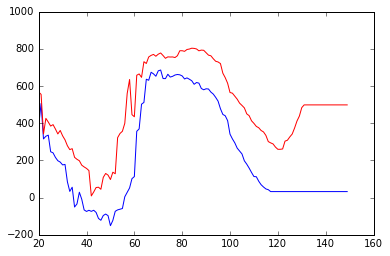

In [21]:
test_sc = StrategyCompare('OU','ni')
test_sc.report(date_list,np.arange(20,150))

In [23]:
test_sc.get_best_param(100,date_list)

{'2016-01-04': ('roll:5000_sd:5.0_spreadcoef:0.0', 'roll:8000_sd:4.0'),
 '2016-01-05': ('roll:5000_sd:5.0_spreadcoef:0.0', 'roll:8000_sd:4.0'),
 '2016-01-06': ('roll:5000_sd:5.0_spreadcoef:0.0', 'roll:8000_sd:4.0'),
 '2016-01-07': ('roll:5000_sd:5.0_spreadcoef:0.0', 'roll:8000_sd:4.0'),
 '2016-01-08': ('roll:5000_sd:5.0_spreadcoef:0.0', 'roll:8000_sd:4.0'),
 '2016-01-11': ('roll:5000_sd:5.0_spreadcoef:0.0', 'roll:8000_sd:4.0'),
 '2016-01-12': ('roll:5000_sd:5.0_spreadcoef:0.0', 'roll:8000_sd:4.0'),
 '2016-01-13': ('roll:5000_sd:5.0_spreadcoef:0.0', 'roll:8000_sd:4.0'),
 '2016-01-14': ('roll:5000_sd:5.0_spreadcoef:0.0', 'roll:8000_sd:4.0'),
 '2016-01-15': ('roll:5000_sd:5.0_spreadcoef:0.0', 'roll:8000_sd:4.0'),
 '2016-01-18': ('roll:5000_sd:5.0_spreadcoef:0.0', 'roll:8000_sd:4.0'),
 '2016-01-19': ('roll:5000_sd:5.0_spreadcoef:0.0', 'roll:8000_sd:4.0'),
 '2016-01-20': ('roll:5000_sd:5.0_spreadcoef:0.0', 'roll:8000_sd:4.0'),
 '2016-01-21': ('roll:5000_sd:5.0_spreadcoef:0.0', 'roll:8000_sd

In [22]:
test_sc.pnl_list_given_param(8000,3.0,date_list)

[('2016-01-04', -452.0, -252.0),
 ('2016-01-05', 630.0, 770.0),
 ('2016-01-06', 168.0, 168.0),
 ('2016-01-07', -656.0, -600.0),
 ('2016-01-08', -700.0, 484.0),
 ('2016-01-11', -736.0, -32.0),
 ('2016-01-12', -54.0, -78.0),
 ('2016-01-13', -2188.0, -1086.0),
 ('2016-01-14', -672.0, -642.0),
 ('2016-01-15', -1770.0, -1512.0),
 ('2016-01-18', 220.0, 286.0),
 ('2016-01-19', 1404.0, 1442.0),
 ('2016-01-20', 566.0, 566.0),
 ('2016-01-21', 376.0, 386.0),
 ('2016-01-22', 758.0, 718.0),
 ('2016-01-25', 26.0, 34.0),
 ('2016-01-26', 410.0, 516.0),
 ('2016-01-27', 874.0, 884.0),
 ('2016-01-28', 666.0, 560.0),
 ('2016-01-29', 510.0, 556.0),
 ('2016-02-01', 536.0, 536.0),
 ('2016-02-02', 668.0, 572.0),
 ('2016-02-03', 380.0, 436.0),
 ('2016-02-04', 474.0, 474.0),
 ('2016-02-05', 198.0, 198.0),
 ('2016-02-15', -118.0, -118.0),
 ('2016-02-16', 286.0, 286.0),
 ('2016-02-17', 266.0, 256.0),
 ('2016-02-18', 292.0, 276.0),
 ('2016-02-19', 462.0, 498.0),
 ('2016-02-22', 524.0, 576.0),
 ('2016-02-23', 560.0